# BruteForce Searching Demo

Demo for unsupervised brute force shaplets searching for anomaly detection 

In [1]:
import sys
sys.path.append('../')

import numpy as np
import random

from tslearn.datasets import CachedDatasets, UCR_UEA_datasets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance

from src.preprocessing_anomaly import preprocessing_anomaly
from src.SVDD.SVDD import SVDD
from src.util import Scaler
from src.searching.bruteforce_multivariate import Bruteforce_extractor_mv, Candidateset

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.svm import OneClassSVM

import matplotlib.pyplot as plt
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"


## Set up the dataset

### Load the data

Download the data (if needed):

In [2]:
# data_name = "Trace"
# X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset(data_name)
# np.save(f'../demo/data/{data_name}_train', X_train)
# np.save(f'../demo/data/{data_name}_train_labels', y_train)
# np.save(f'../demo/data/{data_name}_test', X_test)
# np.save(f'../demo/data/{data_name}_test_labeles', y_test)

Or load the data from saved numpy arrays:

In [3]:
data_name = "Trace"
X_train = np.load(f'../demo/data/{data_name}_train.npy')
y_train = np.load(f'../demo/data/{data_name}_train_labels.npy')
X_test = np.load(f'../demo/data/{data_name}_test.npy')
y_test = np.load(f'../demo/data/{data_name}_test_labeles.npy')

### Preprocessing

#### Get statistics of the entire data:

In [4]:
print(f'Shape of training data: {X_train.shape}')
print(f'Shape of test data: {X_test.shape}')
print(f'The different classes: {set(y_train)}')

# if needed use label encoder to transform the labels from strings to integers
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_test = le.fit_transform(y_test)
# le.classes_

X_total = np.concatenate((X_train, X_test), axis=0)
y_total = np.concatenate((y_train, y_test), axis=0)
print(f'Shape of the total data: {X_total.shape}')

#### check if one class is predominant
obs_perclass = [len(y_total[y_total==i]) for i in set(y_total)]
print(f'Number of total samples in each class: {obs_perclass}')

Shape of training data: (100, 275, 1)
Shape of test data: (100, 275, 1)
The different classes: {1, 2, 3, 4}
Shape of the total data: (200, 275, 1)
Number of total samples in each class: [50, 50, 50, 50]


Use LabelEncoder in case the name of the labels are strings:

In [5]:
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_test = le.fit_transform(y_test)
# print('The positions are the new labels', le.classes_)


Plot one sample per class (first channel in case multivariate):

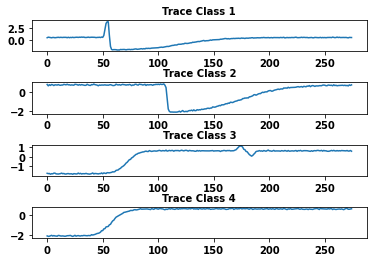

In [6]:
n_class = len(obs_perclass)

fig, ax = plt.subplots(n_class,)

# NOTE: modify if the labels start from 0 or 1
for i in range(n_class):
    ts = X_train[y_train==i+1][0,:,0]
    ax[i].set_title(f'{data_name} Class {i+1}', fontsize=10, fontweight="bold")
    ax[i].plot(ts)
plt.subplots_adjust(hspace=1)
plt.show()

#### Create anomaly detection dataset:

- First the train and test set are merged together
- A proportion "normal_prop" of time series from "normal_class" is selected randomly in the train set
- A proportion "alpha" of the latter set of normal train series is selected randomly from the other classes to represent the anomalies in the train set
- All the other series go in the test set

In [7]:
# Set seed for determinism
np.random.seed(0)

X_train = X_train[np.logical_or(y_train==3, y_train==4)]
y_train = y_train[np.logical_or(y_train==3, y_train==4)]

X_test = X_test[np.logical_or(y_test==3, y_test==4)]
y_test = y_test[np.logical_or(y_test==3, y_test==4)]
# Set up anomaly detection dataset

normal_class = 4 # choose the normal class
normal_prop = 0.15 # proportion of normal samples that go in train set
alpha = 0.1 # proportion of anomalies wrt normal 
X_train_anomaly, y_train_anomaly, X_test_anomaly, y_test_anomaly = preprocessing_anomaly(X_train, y_train, X_test, y_test, alpha, normal_class=normal_class, normal_prop=normal_prop)


Get statistics of the anomaly detection dataset:

In [8]:
N, Q, n_channels = X_train_anomaly.shape
print(f'{data_name} dataset')
print(f'number train ts is {N}, each of length {Q}')
print(f'They belong to two possible classes: {set(y_train_anomaly)}')
print('number test ts', len(X_test_anomaly))
print('number of normal train series:', len(y_train_anomaly[y_train_anomaly==1]))
print('number of anomalous train series:', len(y_train_anomaly[y_train_anomaly==-1]))
print('number of normal test series:', len(y_test_anomaly[y_test_anomaly==1]))
print('number of anomalous test series:', len(y_test_anomaly[y_test_anomaly==-1]))

Trace dataset
number train ts is 9, each of length 275
They belong to two possible classes: {1, -1}
number test ts 91
number of normal train series: 8
number of anomalous train series: 1
number of normal test series: 42
number of anomalous test series: 49


#### Normalize:

Normalize globally:

In [9]:
# normalizer = Scaler(scaler=StandardScaler())
# X_train_anomaly = scaler.fit_transform(X_train_anomaly)
# X_test_anomaly = scaler.transform(X_test_anomaly)

Or locally:

In [10]:
scaler = TimeSeriesScalerMeanVariance()
X_train_anomaly = scaler.fit_transform(X_train_anomaly)
X_test_anomaly = scaler.transform(X_test_anomaly)

#### Plot train and test set

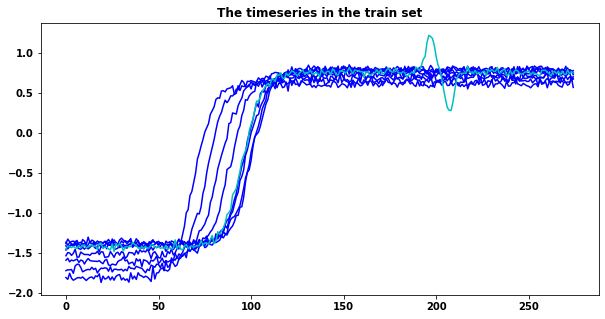

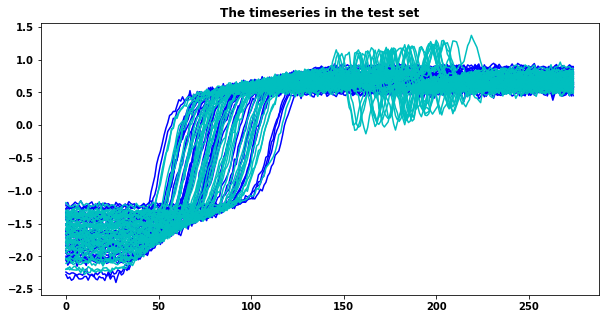

In [11]:
# only first channel in case multivariate
colors = ['r', 'b', 'g', 'y', 'c']

plt.figure(1, figsize=(10, 5))
for ts, label in zip(X_train_anomaly[:,:,0], y_train_anomaly):
    plt.plot(range(len(ts)), ts, c=colors[label%len(colors)])
plt.title('The timeseries in the train set', fontweight="bold")
plt.show()

plt.figure(2, figsize=(10, 5))
for ts, label in zip(X_test_anomaly[:,:,0], y_test_anomaly):
    plt.plot(range(len(ts)), ts, c=colors[label%len(colors)])
plt.title('The timeseries in the test set', fontweight="bold")
plt.show()


## Extract the shapelets from data subsequences

Set up the extractor and hyperparameters:
- K_star: number of shapelets in proportion to length of time series Q
- L_star: length of shapelets in proportion to length of time series
- reverse: bool, whether to take the shapelets with max (True) or min score

In [12]:
extractor = Bruteforce_extractor_mv(train_data=X_train_anomaly, test_data=X_test_anomaly)

K_star = 0.02 # number of shapelets in proportion to length of time series
L_star = 0.2 # length of shapelets in proportion to length of time series
L = round(L_star * Q)

# REVERSE indicates whether the extracted shapelets are the furthest (True) or the nearest (False) to the majority of the time series
reverse = True
pos_boundary = 7

Extract the optimal shapelets:

In [13]:
shapelets = extractor.extract_shapelets(K_star, L_star, pos_boundary=pos_boundary, reverse=reverse)
S = shapelets.sequences
print(f'Positions of the shapelets {shapelets.positions}')
print(f'Scores {shapelets.scores}')

Are going to be extracted 6.000 shapelets of length 55.0000
Shapelets are going to be extracted in reverse order!


timeseries: 100%|██████████| 9/9 [02:07<00:00, 14.11s/it]


[[0.72130241]
 [0.73658241]
 [0.74577878]
 [0.76057255]
 [0.79367541]
 [0.74442818]
 [0.7923622 ]
 [0.74002451]
 [0.74659547]
 [0.78511605]
 [0.81043535]
 [0.79426772]
 [0.76382198]
 [0.76526936]
 [0.80905217]
 [0.76798995]
 [0.75382567]
 [0.74626105]
 [0.76823561]
 [0.75870515]
 [0.70684958]
 [0.72355173]
 [0.74725983]
 [0.76153657]
 [0.7480286 ]
 [0.8251951 ]
 [0.80472236]
 [0.78424964]
 [0.84586498]
 [0.92361307]
 [0.95796418]
 [1.12927941]
 [1.22256207]
 [1.20722576]
 [1.18325624]
 [1.09347134]
 [0.95494235]
 [0.84948796]
 [0.79313458]
 [0.67688359]
 [0.54697995]
 [0.42682012]
 [0.31978068]
 [0.28657359]
 [0.28261174]
 [0.38442248]
 [0.53461858]
 [0.67226147]
 [0.72780696]
 [0.75014828]
 [0.74320957]
 [0.75200894]
 [0.74990835]
 [0.83395071]
 [0.76418109]]
1.0000000000000002
[[0.72130241]
 [0.73658241]
 [0.74577878]
 [0.76057255]
 [0.79367541]
 [0.74442818]
 [0.7923622 ]
 [0.74002451]
 [0.74659547]
 [0.78511605]
 [0.81043535]
 [0.79426772]
 [0.76382198]
 [0.76526936]
 [0.80905217]


Save the shapelets (if needed):

In [27]:
# np.save(f'../Results/{data_name}/s_class34_reverse={reverse}_correlation=0.8', S)

Load the shapelets if are saved in Results:

In [31]:
# in case shapelets are already saved:
S = np.load(f'../Results/{data_name}/class34/s_class34_reverse={reverse}_correlation=0.8.npy')

# set manually the shapelets in extractor
extractor.shapelets = Candidateset()
extractor.shapelets.sequences = S

Plot the shapelets:

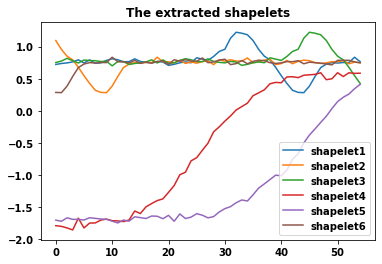

In [32]:
channel = 0
plt.figure()
for i in range(len(S)):
    shap = S[i,:,channel]
    plt.plot(shap, label=f'shapelet{i+1}')
plt.legend()
plt.title('The extracted shapelets', fontweight="bold")
plt.show()

In [26]:
# test the correlation of the shapelets
from src.util import max_corr
K = round(K_star*Q)

corr_matrix = np.zeros((K,K))
for i in range(K):
    for j in range(len(S)):
        corr_matrix[i,j] = max_corr(S[i], S[j])
print(corr_matrix)

[[1.         0.75172022 0.73987469 0.33554347 0.52137948 0.58968978]
 [0.75172022 1.         0.58133428 0.41955978 0.27375051 0.77429192]
 [0.73987469 0.58133428 1.         0.40372208 0.69371125 0.36855475]
 [0.33554347 0.41955978 0.40372208 1.         0.79130134 0.41810034]
 [0.52137948 0.27375051 0.69371125 0.79130134 1.         0.32718961]
 [0.58968978 0.77429192 0.36855475 0.41810034 0.32718961 1.        ]]


Transform the dataset:

In [17]:
# transform both train and test 
X_train_transform, X_test_transform = extractor.transform()
print('Type and shape of transformed train data', type(X_train_transform),  X_train_transform.shape)
print('Type and shape of transformed test data', type(X_test_transform),  X_test_transform.shape)

Type and shape of transformed train data <class 'numpy.ndarray'> (9, 6)
Type and shape of transformed test data <class 'numpy.ndarray'> (91, 6)


## Anomaly detection using SVDD/OCSVM

Choose how many extracted shapelets to take (2 for visualization purposes):

In [18]:
K = round(K_star*Q)
print('The maximum number of shapelets that can be taken is', K)
n_shap = 2 # n_shap must be <= K
X_train_transform = X_train_transform[:,0:n_shap]
X_test_transform = X_test_transform[:,0:n_shap]

The maximum number of shapelets that can be taken is 6


In [19]:
# nu is the proportion of anomalies in the train set w.r.t. the total
nu = np.around(len(y_train_anomaly[y_train_anomaly==-1])/len(y_train_anomaly), 3)
print(nu)

0.111


Fit the OCSVM in transformed space:

In [20]:
ocsvm = OneClassSVM(nu=nu, kernel='linear')

# fit the model
ocsvm.fit(X_train_transform)

OneClassSVM(kernel='linear', nu=0.111)

EVALUATE the prediction:

In [21]:
## TRAIN
# BALANCED ACCURACY
y_train_predict = ocsvm.predict(X_train_transform)
train_ba = balanced_accuracy_score(y_train_anomaly, y_train_predict)
print("OCSVM train balanced accuracy:", train_ba)

# AUC
y_train_scores = ocsvm.decision_function(X_train_transform)
auc_train = roc_auc_score(y_train_anomaly, y_train_scores)
print("OCSVM train AUC:", auc_train)

# F1 score
f1_train = f1_score(y_train_anomaly, y_train_predict)
print("OCSVM train F1 score:", f1_train)

## TEST
# BALANCED ACCURACY
y_test_predict = ocsvm.predict(X_test_transform)
test_ba = balanced_accuracy_score(y_test_anomaly, y_test_predict)
print("OCSVM test balanced accuracy:", test_ba)

# AUC
y_test_scores = ocsvm.decision_function(X_test_transform)
auc_test = roc_auc_score(y_test_anomaly, y_test_scores)
print("OCSVM test AUC:", auc_test)

# F1 score
f1_test = f1_score(y_test_anomaly, y_test_predict)
print("OCSVM test F1 score:", f1_test)

OCSVM train balanced accuracy: 0.625
OCSVM train AUC: 1.0
OCSVM train F1 score: 0.4
OCSVM test balanced accuracy: 0.7142857142857143
OCSVM test AUC: 1.0
OCSVM test F1 score: 0.6


Confusion matrix

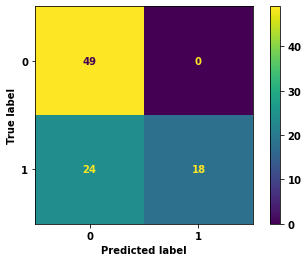

In [22]:
# Confusion matrix for test 
cm = confusion_matrix(y_test_anomaly, y_test_predict)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()

ROC and overlapping histograms plot

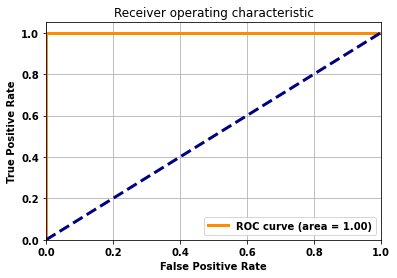

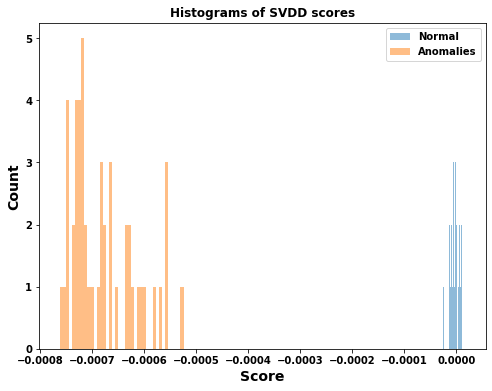

In [23]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test_anomaly, y_test_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=3, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.grid()
plt.show()
# plt.savefig('ROC_test.png')

# OVERLAPPING HISTOGRAMS PLOT of SVDD scores (test data)

plt.figure(figsize=(8,6))
plt.hist(y_test_scores[y_test_anomaly==1], bins=40, alpha=0.5, label="Normal")
plt.hist(y_test_scores[y_test_anomaly==-1], bins=40, alpha=0.5, label="Anomalies")

plt.xlabel("Score", size=14)
plt.ylabel("Count", size=14)
plt.title("Histograms of SVDD scores", fontweight="bold")
plt.legend(loc='upper right')
plt.show()

### PLOTS (first two coordinates in shapelet transformed space):

NOTE: if were taken more than 2 shapelets the SVDD boundaries are plotted but they do not indicate the correct boundary in the true points in greater dimension (the points are collapsed in the plane as if their other coordinates were equal to zero)

TRAIN DATA and SVDD boundary

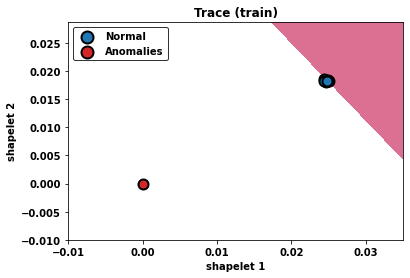

In [24]:
x_max = max(X_train_transform[:,0])+0.01
y_max = max(X_train_transform[:,1])+0.01
xx, yy = np.meshgrid(np.linspace(-0.1, x_max, 500), np.linspace(-0.1, y_max, 500))
Z = ocsvm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
pIndex_train = y_train_anomaly == 1
nIndex_train = y_train_anomaly == -1


plt.figure()
plt.title(f"{data_name} (train)", fontweight="bold")

plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")
plt.scatter(X_train_transform[pIndex_train, 0], X_train_transform[pIndex_train, 1], facecolor='C0', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Normal")

plt.scatter(X_train_transform[nIndex_train, 0], X_train_transform[nIndex_train, 1], facecolor='C3', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Anomalies")

plt.legend(ncol=1, loc='upper left', edgecolor='black',
                    markerscale=1.2, fancybox=True)
plt.xlim((-0.01, x_max))
plt.ylim((-0.01, y_max))
plt.ylabel("shapelet 2")
plt.xlabel("shapelet 1")
plt.show()

TEST DATA and SVDD boundary

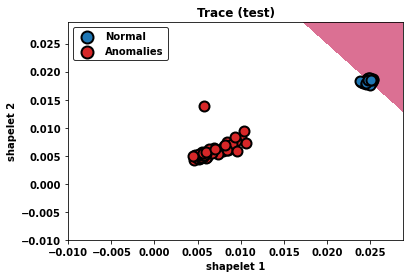

In [25]:
x_max = max(X_test_transform[:,0])+0.01
y_max = max(X_test_transform[:,1])+0.01
xx, yy = np.meshgrid(np.linspace(-0.1, x_max, 500), np.linspace(-0.1, y_max, 500))
Z = ocsvm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
pIndex_test = y_test_anomaly == 1
nIndex_test = y_test_anomaly == -1
auc_test = np.around(auc_test, 3)
plt.figure()
plt.title(f"{data_name} (test)", fontweight="bold")

plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")
plt.scatter(X_test_transform[pIndex_test, 0], X_test_transform[pIndex_test, 1], facecolor='C0', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Normal")

plt.scatter(X_test_transform[nIndex_test, 0], X_test_transform[nIndex_test, 1], facecolor='C3', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Anomalies")

plt.legend(ncol=1, loc='upper left', edgecolor='black',
                     markerscale=1.2, fancybox=True)

plt.xlim((-0.01, y_max))
plt.ylim((-0.01, y_max))
plt.ylabel("shapelet 2")
plt.xlabel("shapelet 1")
plt.show()